In [1]:
from collections.abc import Sequence
import json
from pathlib import Path
import re
from typing import Any

import h5py
import matplotlib.pyplot as plt
import nrrd
import numpy as np
from scipy.spatial.distance import euclidean
import vedo

from histalign.backend.models import AlignmentSettings, Orientation
from histalign.backend.registration import Registrator
from histalign.backend.registration.alignment import build_aligned_array
from histalign.backend.workspace import VolumeSlicer

vedo.settings.default_backend = "vtk"

In [2]:
PathType = str | Path

ALIGNMENT_FILE_NAME_PATTERN = re.compile(r"[0-9a-f]{32}\.json")
_SUPPORTED_TYPES = [".h5", ".hdf5", ".nrrd", ".json"]


def imshow(image: np.ndarray) -> None:
    plt.imshow(image)
    plt.axis(False)
    plt.show()


def show(objects: object | Sequence[object]) -> None:
    try:
        objects = [] + objects
    except TypeError:
        objects = [objects]

    vedo.show(
        objects,
        interactive=False,
    ).interactive().close()


def load_file(path: PathType) -> Any:
    path = Path(path)
    if (suffix := path.suffix) not in _SUPPORTED_TYPES:
        raise ValueError(
            f"File extension not supported. Received: {suffix}. Allowed: {' '.join(_SUPPORTED_TYPES)}"
        )

    if suffix == ".json":
        data = json.load(path.open())
    elif suffix == ".nrrd":
        data = nrrd.read(path)[0]
    elif suffix in [".h5", ".hdf5"]:
        with h5py.File(path) as handle:
            data = handle[list(handle.keys())[0]][:]

    return data

In [3]:
atlas_path = "/home/ediun/.local/share/histalign/atlases/average_template_100.nrrd"
atlas_array = load_file(atlas_path)
atlas_volume = vedo.Volume(atlas_array)

alignment_directory = Path(
    "/home/ediun/histalign-projects/microns_100_coronal_2d_artificial/1a862cb4e4"
)
alignment_paths = []
for child_path in alignment_directory.iterdir():
    if (
        child_path.is_dir()
        or re.fullmatch(ALIGNMENT_FILE_NAME_PATTERN, child_path.name) is None
    ):
        continue

    alignment_paths.append(child_path)
alignment_settings = [AlignmentSettings(**load_file(path)) for path in alignment_paths]
build_aligned_array(alignment_directory, "", "", "")
alignment_array = load_file(
    "/home/ediun/histalign-projects/microns_100_coronal_2d_artificial/1a862cb4e4/volumes/aligned/1a862cb4e4.h5"
)
alignment_volume = vedo.Volume(alignment_array)

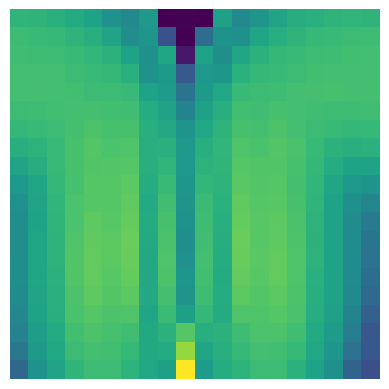

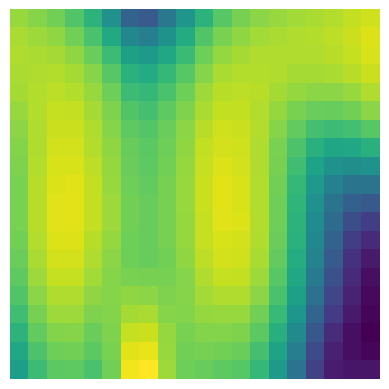

In [7]:
atlas_slicer = VolumeSlicer(volume=atlas_volume)
target_image = atlas_slicer.slice(alignment_settings[0].volume_settings)

alignment_slicer = VolumeSlicer(volume=alignment_volume)
actual_image = alignment_slicer.slice(alignment_settings[0].volume_settings)

# roi = (slice(None), slice(None))
roi = (slice(75, 95), slice(90, 110))

imshow(target_image[roi])
imshow(actual_image[roi])